# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
### Load the Data from Pickle File without having to run things from the beginning
import tensorflow as tf
from tensorflow.python.ops.variables import Variable
import cv2
import numpy as np
import scipy.ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import pickle
import os
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
%matplotlib inline


def get_data():
    # TODO: fill this in based on where you saved the training and testing data
    training_file = "traffic-signs-data/train.p"
    testing_file = "traffic-signs-data/test.p"

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']

    return X_train, y_train, X_test, y_test


def make_gray(X_train, X_test):
    # Create an array to hold a grayscale image vector for each image sample in the training dataset
    X_train_gray = np.empty([*X_train.shape[0:3], 1], np.float32)

    # Create an array to hold a grayscale image for each image in the test dataset
    X_test_gray = np.empty([*X_test.shape[0:3], 1], np.float32)

    for i in range(len(X_train)):
        X_train_gray[i, :, :, 0] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
        
            
    for i in range(len(X_test)):
        X_test_gray[i, :, :, 0] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)

    return X_train_gray, X_test_gray


def make_yuv(features, test):
    yuv_features = np.empty([*features.shape], np.uint8)
    yuv_test = np.empty([*test.shape], np.uint8)
    
    for i in range(len(features)):
        yuv_features[i] = cv2.cvtColor(features[i], cv2.COLOR_BGR2YUV)
    
    for i in range(len(test)):
        yuv_test[i] = cv2.cvtColor(test[i], cv2.COLOR_BGR2YUV)
    
    return yuv_features.astype(np.uint8), yuv_test.astype(np.uint8)


### To start off let's do a basic data summary.
def get_summary(X_train, y_train, X_test, y_test):
    # TODO: number of training examples
    n_train = X_train.shape[0]

    # TODO: number of testing examples
    n_test = X_test.shape[0]

    # TODO: what's the shape of an image?
    image_shape = X_train.shape[1:4]

    # TODO: how many classes are in the dataset
    n_classes = max(y_train) + 1
    
    return n_train, n_test, image_shape, n_classes


## Count the number of images per class
def count_classes(labels, n_classes):
    class_no = 0
    count = 0
    class_count = np.zeros((n_classes), np.int32)
    class_idx = np.zeros((n_classes), np.int32)
    
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    
    for l in labels:
        class_count[l] += 1
    
    for c in range(1, len(class_count)):
        class_idx[c] = class_idx[c-1] + class_count[c-1]
        
    return class_count, class_idx


## Create a smaller subset of the training data that has enough images for each class
def make_subset(features, labels, n_classes=43, track_size=30, threshold=600, reduction=4):
    class_count, class_idx = count_classes(labels, n_classes)
    num_tracks = class_count/track_size
    num_tracks = num_tracks.astype(np.int32)
    
    x_subset = np.copy(features)
    y_subset = np.copy(labels)
    delete_range = np.array([])
    
    del_perct = 1.0-1.0/reduction
    for n in range(len(num_tracks)):
        if num_tracks[n]*track_size > threshold:
            # Select the tracks to delete
            a = np.arange(num_tracks[n])
            a = np.random.permutation(a)
            end = int(del_perct*len(a))
            a = a[0:end]
            a = np.sort(a).astype(np.int32)
            for i in a:
                delete_range = np.append(delete_range, 
                                         range(i*track_size + class_idx[n], (i+1)*track_size + class_idx[n]))
                
    x_subset = np.delete(x_subset, delete_range, axis=0)
    y_subset = np.delete(y_subset, delete_range, axis=0)     
    
    return x_subset, y_subset


## Normalize the data
def normalize_data(data):
    data_norm = data/255.0
#     data_norm = np.copy(data).astype(np.float32)
#     data_norm -= np.mean(data_norm, axis=0)
#     data_norm /= np.std(data_norm, axis=0)
#     for d in data_norm:
#         for i in range(d.shape[-1]):
#             d[:, :, i] = (d[:, :, i] - np.mean(d[:, :, i]))/np.std(d[:, :, i])
            
    return data_norm


## Adding Synthetic Data
def add_synthetic_data(features, labels, tfms=['fliplr', 'rotate', 'blur'], max_angle=20, max_sigma=0.5):
    class_count, class_idx = count_classes(labels, max(labels)+1)
    new_len = (len(tfms) + 1)*len(features)
    X_mod = np.empty((new_len, *features.shape[1:]), features.dtype)
    y_mod = np.empty((new_len, *labels.shape[1:]), labels.dtype)
    index = 0
    
    for c in range(len(class_count)):
        X_mod[index:index + class_count[c]] = np.copy(features[class_idx[c]:class_idx[c] + class_count[c]])
        y_mod[index:index + class_count[c]] = np.copy(labels[class_idx[c]:class_idx[c] + class_count[c]])
        index += class_count[c]
                 
        for op in tfms:
            for i in range(class_idx[c], class_idx[c] + class_count[c]):
                if op == 'fliplr':
                    X_mod[index] = np.fliplr(features[i])
                if op == 'flipud':
                    X_mod[index] = np.flipud(features[i])
                if op == 'rotate':
                    angle = random.uniform(-max_angle, max_angle)
                    X_mod[index] = scipy.ndimage.interpolation.rotate(features[i], angle, reshape=False) 
                if op == 'blur':
                    sigma = random.uniform(0., max_sigma)
                    X_mod[index] = scipy.ndimage.filters.gaussian_filter(features[i], sigma)
                y_mod[index] = labels[i]
                index += 1   

    return X_mod, y_mod

def make_encoder(labels):
    encoder = LabelBinarizer()
    encoder.fit(labels)
    
    return encoder

def one_hot_transform(labels, encoder):
    train_labels = encoder.transform(labels)
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)

    return train_labels

def select_data(features, labels, subset_len=1290):
    _, train_features, _, train_labels = train_test_split(
        features,
        labels,
        test_size=subset_len,
        random_state=832289,
        stratify = labels)
    
    return train_features, train_labels

def make_train_test(features, labels, op='track_split', n_classes=43, split_size=0.20, track_size=30):
    
    if op == 'random_split':
        # Get randomized datasets for training and validation
        train_features, valid_features, train_labels, valid_labels = train_test_split(
            features,
            labels,
            test_size=split_size,
            random_state=832289,
            stratify = labels)
        
    elif op == 'track_split':
        class_count, class_idx = count_classes(labels, n_classes)
        
        # Copy the features and labels because we're going to delete the validation set from them
        train_features = np.copy(features)
        train_labels = np.copy(labels)
        valid_features = np.empty((len(class_count)*track_size, *train_features[0].shape), train_features.dtype)
        if len(labels.shape) == 1:
            valid_labels = np.empty((len(class_count)*track_size), train_labels.dtype)
        else:
            valid_labels = np.empty((len(class_count)*track_size, labels.shape[-1]), train_labels.dtype)
        delete_range = np.empty((len(class_count), track_size), np.int32)
        num_tracks = class_count/track_size
        num_tracks = num_tracks.astype(np.int32)
        
        # Randomly select a track from each class and add to the validation set
        for t in range(len(num_tracks)):        
            track_num = np.random.randint(num_tracks[t])
            track_range = range(track_num*track_size + class_idx[t], (track_num+1)*track_size + class_idx[t])
            valid_features[t*track_size:(t+1)*track_size] = features[track_range]
            valid_labels[t*track_size:(t+1)*track_size] = labels[track_range]
            delete_range[t] = track_range
        # Remove the samples that were added to the validation set
        train_features = np.delete(train_features, delete_range, axis=0) 
        train_labels = np.delete(train_labels, delete_range, axis=0) 
        
        # Shuffle the validation and training sets
        valid_features, valid_labels = shuffle(valid_features, valid_labels)
        train_features, train_labels = shuffle(train_features, train_labels)
        
    else:
        print('The split operation provided is not valid')
        return
    
    return train_features, valid_features, train_labels, valid_labels


def print_images(data, indices=[]):
    if len(data.shape) <= 3:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        if (data.shape[-1] == 1):
            data = data[:, :, 0]
            ax.imshow(data, cmap='gray')
        else:
            ax.imshow(data)
        if len(indices) > 0:
            print(indices[0])
        plt.show()
    elif len(data.shape) >= 4:
        for d in range(len(data)):
            fig = plt.figure()
            ax = fig.add_subplot(111)
            if (data[d].shape[-1] == 1):
                ax.imshow(data[d, :, :, 0], cmap='gray')
            else:
                ax.imshow(data[d])
            if len(indices) > 0:
                print(indices[d])
            plt.show()
            
def print_class(features, labels, class_no, image_idx):
    if len(labels.shape) > 1:
        if len(labels) == 1:
            indices_by_class = np.where(np.argmax(labels) == class_no)
        else:
            indices_by_class = np.where(np.argmax(labels, axis=1) == class_no)[0]
    else:
        if len(labels) == 1:
            indices_by_class = np.where(labels == class_no)
        else:
            indices_by_class = np.where(labels == class_no)[0]
            
    features_by_class = features[indices_by_class]
    images = features_by_class[image_idx]
    print_images(images, image_idx)

print('Helper Functions Created')


Helper Functions Created


In [2]:
# Some booleans for activating data modification functions
grayscale = False
yuv = False
subset = False
synth = True
tfms = ['rotate', 'blur']
norm = True
ops = 'track_split'

X_train, y_train, X_test, y_test = get_data()
n_train, n_test, image_shape, n_classes = get_summary(X_train, y_train, X_test, y_test)
class_count, class_idx = count_classes(y_train, n_classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Make copies of the original data to preserve the originals incase we need them later
train_features = np.copy(X_train)
train_labels = np.copy(y_train)
test_features = np.copy(X_test)
test_labels = np.copy(y_test)


## Modify the data set 
if grayscale ^ yuv:
    if grayscale:
        # Make grayscale test and training images
        train_features, test_features = make_gray(train_features, test_features)
    
    if yuv:
        train_features, test_features = make_yuv(train_features, test_features)
        
if subset:
    # Create a subset of the data
    train_features, train_labels = make_subset(train_features, train_labels)
    n_train, n_test, image_shape, n_classes = get_summary(train_features, train_labels, test_features, test_labels)
    print("Number of training examples =", n_train)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    
if synth:
    train_features, train_labels = add_synthetic_data(train_features, train_labels, tfms=tfms)

if norm:
    # Normalize the test and training images
    train_features = normalize_data(train_features)
    test_features = normalize_data(test_features)

train_features, valid_features, train_labels, valid_labels = make_train_test(train_features, train_labels, 
                                                                             op=ops)

train_dict_features, train_dict_labels = select_data(train_features, train_labels, 
                                                     subset_len=len(valid_features))
    
print(train_features.shape, valid_features.shape, test_features.shape,
      train_dict_features.shape, train_dict_labels.shape, train_labels.shape, valid_labels.shape, test_labels.shape)

encoder = make_encoder(train_labels)
train_labels = one_hot_transform(train_labels, encoder)
valid_labels = one_hot_transform(valid_labels, encoder)                                                                      
test_labels = one_hot_transform(test_labels, encoder)
train_dict_labels = one_hot_transform(train_dict_labels, encoder)

print(train_labels.shape, train_dict_labels.shape, valid_labels.shape, test_labels.shape)

cc, ci = count_classes(train_labels, n_classes)
print(cc)
cc2, ci2 = count_classes(valid_labels, n_classes)
print(cc2)
cc3, ci3 = count_classes(train_dict_labels, n_classes)
print(cc3)

print('Data Created')

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(116337, 32, 32, 3) (1290, 32, 32, 3) (12630, 32, 32, 3) (1290, 32, 32, 3) (1290,) (116337,) (1290,) (12630,)
(116337, 43) (1290, 43) (1290, 43) (12630, 43)
[ 600 6630 6720 4200 5910 5550 1230 4290 4200 4380 6000 3930 6270 6450 2310
 1860 1230 3300 3570  600 1050  960 1140 1500  780 4470 1770  690 1590  780
 1320 2310  690 2037 1230 3570 1140  600 6180  870 1050  690  690]
[30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30]
[ 7 73 74 46 65 61 14 47 46 48 66 43 69 71 26 21 14 37 39  7 12 11 13 17  9
 49 20  8 18  9 15 26  8 22 14 39 13  7 68 10 12  8  8]
Data Created


In [5]:
def conv_layer(input_layer, filter_size, num_input_channels, num_filters, stride=1, padding='SAME',
               relu=False, pooling=False, pool_size=2, drop=False, keep_prob=0.5, name=None):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create filter weights with the given shape.
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    # print(weights.get_shape())

    # Create new biases, one for each filter.
    biases = tf.Variable(tf.zeros(num_filters))

    # Create the convolution operation
    conv_layer = tf.nn.conv2d(input=input_layer,
                             filter=weights,
                             strides=[1, stride, stride, 1],
                             padding=padding)

    # Add the biases to the convolution output
    conv_layer = tf.nn.bias_add(conv_layer, biases)
    
    if relu:
        # Create the ReLu activation function
        conv_layer = tf.nn.relu(conv_layer)
        
    if drop:
        # Use Dropout to prevent overfitting
        conv_layer = tf.nn.dropout(conv_layer, keep_prob)
        
    if pooling == 'max':
        # Create max-pooling
        conv_layer = tf.nn.max_pool(value=conv_layer,
                               ksize=[1, pool_size, pool_size, 1],
                               strides=[1, pool_size, pool_size, 1],
                               padding=padding)
    if pooling == 'average':
        # Create average-pooling
        conv_layer = tf.nn.avg_pool(value=conv_layer,
                               ksize=[1, pool_size, pool_size, 1],
                               strides=[1, pool_size, pool_size, 1],
                               padding=padding)

    print(conv_layer.get_shape())
    
    return conv_layer

def flatten_layer(input_layer):
    layer_shape = input_layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features]
    flat_layer = tf.reshape(input_layer, [-1, num_features])
    print(flat_layer.get_shape())
    
    return (flat_layer)
    
def fc_layer(input_layer, num_features, fc_size, relu=False, drop=False, keep_prob=0.5):
    ## Create the 1st Fully Connected layer
    # Create new weights and biases.
    shape=[num_features, fc_size]

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    biases = tf.Variable(tf.zeros(fc_size))

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    fc_layer = tf.nn.bias_add(tf.matmul(input_layer, weights), biases)
    
    if relu:
        fc_layer = tf.nn.relu(fc_layer)
    
    if drop:
        fc_layer = tf.nn.dropout(fc_layer, keep_prob)
    print(fc_layer.get_shape())
    
    return fc_layer

print('Network Helper Functions Created')


Network Helper Functions Created


In [6]:
### Create a ConvNet
from tensorflow.contrib.layers import flatten

# Create the input data placeholders
features = tf.placeholder(tf.float32, shape=[None, *train_features.shape[1:]])
labels = tf.placeholder(tf.float32, shape=[None, train_labels.shape[-1]])

filter_size = 5
output_size = 6

# Conv Layer 1
conv_layer_1 = conv_layer(features, filter_size, train_features.shape[-1], output_size, 
                          padding='VALID', relu=True)

# Conv Layer 2
conv_layer_2 = conv_layer(conv_layer_1, filter_size, output_size, 16, 
                          padding='VALID', relu=True)

# Conv Layer 3
conv_layer_3 = conv_layer(conv_layer_2, filter_size, 16, 32, 
                          padding='VALID', pooling='max', relu=True, drop=True)

# Flatten layer
flat_layer = flatten(conv_layer_3)
print(flat_layer.get_shape())

# Fully Connected Layer 1
num_features = int(flat_layer.get_shape()[-1])
fc1_size = 120
fc_layer_1 = fc_layer(flat_layer, num_features, fc1_size, relu=True)

# Fully Connected Layer 2
fc2_size = 84
fc_layer_2 = fc_layer(fc_layer_1, fc1_size, fc2_size, relu=True)

# Output Layer
output_layer = fc_layer(fc_layer_2, fc2_size, train_labels.shape[-1])

print('Architecture Created')

(?, 28, 28, 6)
(?, 24, 24, 16)
(?, 10, 10, 32)
(?, 3200)
(?, 120)
(?, 84)
(?, 43)
Architecture Created


In [7]:
## Creating the Softmax predictions, loss, and optimizer functions
prediction = tf.nn.softmax(output_layer)
y_pred_cls = tf.argmax(prediction, 1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_layer, labels))

learning_rate = 0.001

# Gradient Descent
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Test model
correct_prediction = tf.equal(y_pred_cls, tf.argmax(labels, 1))

# Calculate accuracy
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={features: batch_x, labels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('Optimization and Evaluation Functions Created')

Optimization and Evaluation Functions Created


In [8]:
# Import shuffle from sklearn to shuffle training data after every epoch
from sklearn.utils import shuffle

# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()
init = tf.initialize_all_variables()

# The file path to save the data
save_file = 'model_rgb.ckpt'

valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}
train_feed_dict = {features: train_dict_features, labels: train_dict_labels}

def train_model(train_features, train_labels, run_count, epochs, batch_size, save_file):
    # Launch the graph
    with tf.Session() as sess:
        if run_count == 0:
            print('Initiating the Model')
            sess.run(init)
        else:
            print('Restoring a Saved Model')
            saver.restore(sess, save_file)
        
        batch_count = int(math.ceil(len(train_features)/batch_size))
        
        # Training cycle
        for epoch_i in range(epochs):
            # Shuffle the training data
            train_features, train_labels = shuffle(train_features, train_labels)
            # Progress bar
            batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

            # The training cycle
            for batch_i in batches_pbar:
                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                if batch_start >= len(train_features):
                    break
                batch_end = min(batch_start + batch_size, len(train_features))
                batch_features = train_features[batch_start:batch_end]
                batch_labels = train_labels[batch_start:batch_end]

                # Run optimizer and get loss
                _, l = sess.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})

            # Check accuracy against Validation data
            validation_accuracy = evaluate(valid_features, valid_labels, batch_size)
            training_accuracy = evaluate(train_dict_features, train_dict_labels, batch_size)
                  
            # Display logs per epoch step
            print("Epoch:", '%04d' % (epoch_i+1), "loss=", "{:.9f}".format(l)) 
            print("Validation Accuracy=", "{:.9f}".format(validation_accuracy), 
                  "Training Accuracy=", "{:.9f}".format(training_accuracy))

        print("Optimization Finished!") 

        # Save the model
        saver.save(sess, save_file)
        print('Model Saved to ' + save_file)

        # Check accuracy against Validation data
        validation_accuracy = sess.run(accuracy_operation, feed_dict=valid_feed_dict)
        print('Validation accuracy at {}'.format(validation_accuracy))

        # Check accuracy against Validation data
        test_accuracy = sess.run(accuracy_operation, feed_dict=test_feed_dict)
        print('Test accuracy at {}'.format(test_accuracy))

        exam_size = 500
        y_labels = tf.placeholder(tf.float32, shape=[None, n_classes])
        y_true_cls = tf.argmax(y_labels, 1)
        cls_true, cls_pred = sess.run([y_true_cls, y_pred_cls], feed_dict={features: test_features[0:exam_size], 
                                                                       y_labels: test_labels[0:exam_size]})
        
        run_count += epochs
        sess.close()
        return run_count, confusion_matrix(cls_true, cls_pred), cls_true == cls_pred

print('Training Model Created')

Training Model Created


In [7]:
run_count = 0
run_count, cm, ct = train_model(train_features, train_labels, run_count, 10, 30, save_file)

Initiating the Model


Epoch  1/10: 100%|██████████| 3878/3878 [04:22<00:00, 16.27batches/s]


Epoch: 0001 loss= 0.023982750
Validation Accuracy= 0.955813943 Training Accuracy= 0.975968982


Epoch  2/10: 100%|██████████| 3878/3878 [04:18<00:00, 15.01batches/s]


Epoch: 0002 loss= 0.001516607
Validation Accuracy= 0.975968983 Training Accuracy= 0.986046504


Epoch  3/10: 100%|██████████| 3878/3878 [04:28<00:00, 14.43batches/s]


Epoch: 0003 loss= 0.126193404
Validation Accuracy= 0.978294564 Training Accuracy= 0.990697667


Epoch  4/10: 100%|██████████| 3878/3878 [04:30<00:00, 14.31batches/s]


Epoch: 0004 loss= 0.000867115
Validation Accuracy= 0.975968979 Training Accuracy= 0.990697667


Epoch  5/10: 100%|██████████| 3878/3878 [04:36<00:00, 14.03batches/s]


Epoch: 0005 loss= 0.001306775
Validation Accuracy= 0.988372087 Training Accuracy= 0.996124028


Epoch  6/10: 100%|██████████| 3878/3878 [04:37<00:00, 13.97batches/s]


Epoch: 0006 loss= 0.000503667
Validation Accuracy= 0.989922475 Training Accuracy= 0.991472864


Epoch  7/10: 100%|██████████| 3878/3878 [04:35<00:00, 14.09batches/s]


Epoch: 0007 loss= 0.000618223
Validation Accuracy= 0.988372085 Training Accuracy= 0.996124028


Epoch  8/10: 100%|██████████| 3878/3878 [04:37<00:00, 13.95batches/s]


Epoch: 0008 loss= 0.004281449
Validation Accuracy= 0.988372086 Training Accuracy= 0.994573640


Epoch  9/10: 100%|██████████| 3878/3878 [04:35<00:00, 14.07batches/s]


Epoch: 0009 loss= 0.000008406
Validation Accuracy= 0.986821697 Training Accuracy= 0.989922472


Epoch 10/10: 100%|██████████| 3878/3878 [04:32<00:00, 14.23batches/s]


Epoch: 0010 loss= 0.000070531
Validation Accuracy= 0.981395343 Training Accuracy= 0.993023253
Optimization Finished!
Model Saved to model_rgb.ckpt
Validation accuracy at 0.986821711063385
Test accuracy at 0.952414870262146


In [9]:
def plot_confusion_matrix(cm, n_classes=None):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Print the confusion matrix as text.
    print(cm)
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    if n_classes is None:
        n_classes = cm.shape[0]
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [27]:
# plot_confusion_matrix(cm)


In [9]:
# save_file = 'model_rgb.ckpt'
# saver = tf.train.Saver()

# # Launch the graph
# with tf.Session() as sess:
#     saver.restore(sess, save_file)

#     # Check accuracy against Validation data
#     test_accuracy = sess.run(accuracy_operation, feed_dict=test_feed_dict)
#     print('Test accuracy at {}'.format(test_accuracy))

#     exam_size = 500
#     y_labels = tf.placeholder(tf.float32, shape=[None, n_classes])
#     y_true_cls = tf.argmax(y_labels, 1)
#     cls_true, cls_pred = sess.run([y_true_cls, y_pred_cls], feed_dict={features: test_features[0:exam_size], 
#                                                                    y_labels: test_labels[0:exam_size]})
#     print(cls_true)
#     print('--------')
#     print(cls_pred)

#     sess.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Load the new images
new_images = np.array([mpimg.imread('cropped_images/' + name) for name in os.listdir('cropped_images/')])
new_images = normalize_data(new_images)
print(new_images.shape)

(53, 32, 32, 3)


In [11]:
# Associate labels with the new images
new_images_labels = np.tile(np.array([0]), 10)
new_images_labels = np.append(new_images_labels, np.tile(np.array([1]), 8))
new_images_labels = np.append(new_images_labels, np.tile(np.array([2]), 9))
new_images_labels = np.append(new_images_labels, np.tile(np.array([3]), 9))
new_images_labels = np.append(new_images_labels, np.tile(np.array([4]), 9))
new_images_labels = np.append(new_images_labels, np.tile(np.array([5]), 8))

print(new_images_labels.shape)
print(new_images_labels)
num_classes = max(new_images_labels) + 1

new_images_labels = one_hot_transform(new_images_labels, encoder)
print(new_images_labels.shape)
print(new_images_labels[21])

(53,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5]
(53, 43)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [20]:
# Run the saved TF model on the new images to calculate accuracy
save_file = 'model_rgb.ckpt'
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)
    # Check accuracy against Validation data
    new_data_accuracy, cls_true, cls_pred = sess.run([accuracy_operation, y_true_cls, y_pred_cls],
                                                      feed_dict={features: new_images, labels: new_images_labels})
    print('New data accuracy at {}'.format(new_data_accuracy))
    cm = confusion_matrix(cls_true, cls_pred, labels=range(43))
    plot_confusion_matrix(cm, 43)
    
    sess.close()


NotFoundError: Tensor name "Variable_12" not found in checkpoint files model_rgb.ckpt
	 [[Node: save_9/restore_slice_4 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_9/Const_0, save_9/restore_slice_4/tensor_name, save_9/restore_slice_4/shape_and_slice)]]

Caused by op 'save_9/restore_slice_4', defined at:
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-6e37b42b1157>", line 3, in <module>
    saver = tf.train.Saver()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Variable_12" not found in checkpoint files model_rgb.ckpt
	 [[Node: save_9/restore_slice_4 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_9/Const_0, save_9/restore_slice_4/tensor_name, save_9/restore_slice_4/shape_and_slice)]]


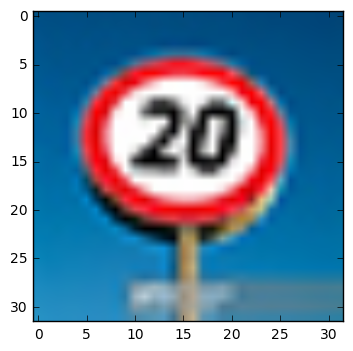

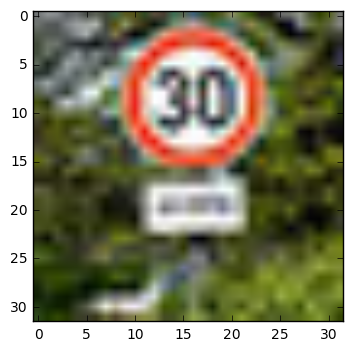

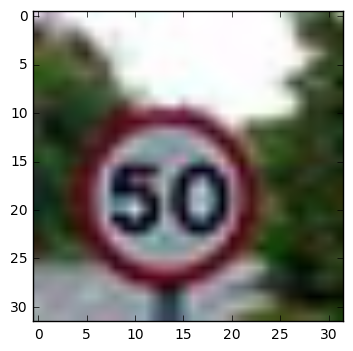

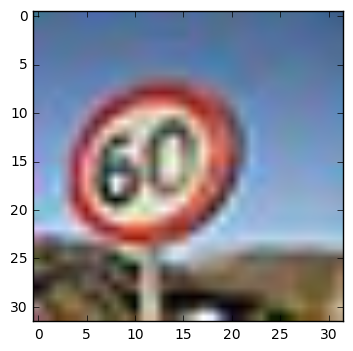

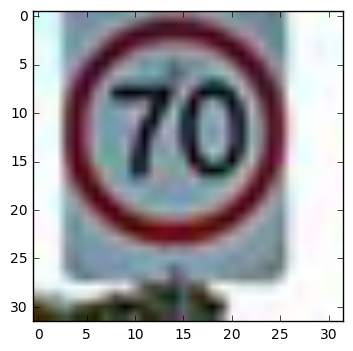

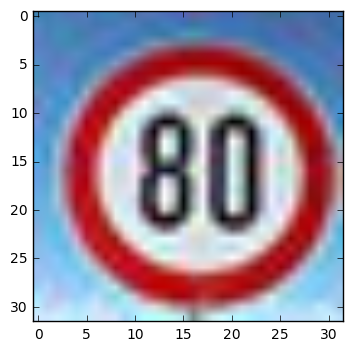

In [106]:
print_images(new_images[0])
print_images(new_images[10])
print_images(new_images[18])
print_images(new_images[29])
print_images(new_images[36])
print_images(new_images[46])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** I show examples of images from class 0, 1, 2, 3, 4, and 5 above. These are images that were incorrectly classified by the model. Some of the images show the signs at an angle, which would perhaps make classification more difficult. Others have additional signs beneath the main sign, which could add some noise to the classification. 

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [133]:
top_5 = tf.nn.top_k(predictions, k=5)

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)
    probabilities, top_5_prob = sess.run([prediction, top_5],
                                    feed_dict={features: new_images, labels: new_images_labels})
    plt.matshow(probabilities)
    plt.colorbar()
    print(top_5_prob)
    sess.close()


    

NotFoundError: Tensor name "Variable_12" not found in checkpoint files model_rgb.ckpt
	 [[Node: save_35/restore_slice_12 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_35/Const_0, save_35/restore_slice_12/tensor_name, save_35/restore_slice_12/shape_and_slice)]]

Caused by op 'save_35/restore_slice_12', defined at:
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-133-f94f473157cf>", line 4, in <module>
    saver = tf.train.Saver()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Variable_12" not found in checkpoint files model_rgb.ckpt
	 [[Node: save_35/restore_slice_12 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_35/Const_0, save_35/restore_slice_12/tensor_name, save_35/restore_slice_12/shape_and_slice)]]


In [127]:
print(top_5)

TopKV2(values=<tf.Tensor 'TopKV2_2:0' shape=(53, 5) dtype=float32>, indices=<tf.Tensor 'TopKV2_2:1' shape=(53, 5) dtype=int32>)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.